In [3]:
import os
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
from typing import Tuple

import pandas as pd
from Futures import FutureContract, Spot
from price_impact import regression_path
from price_impact import tickers as spots
from price_impact.modelling.backtest_analysis import BacktestSettings, BacktestResults
from price_impact.modelling.Futures import FutureContract
from BloombergAccessor import BLP

import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
results_list = []

backtest_settings = BacktestSettings(
    train_len=6,
    test_len=3,
    bin_freq='10s',
    forecast_horizon_s=10,
    smoothing_str='sma20',
    decay=3600

)


def get_stat_dict(spot):
    backtest_results = BacktestResults(spot, backtest_settings)
    _, _, _ = backtest_results.create_and_save_plots()
    stat_dict = backtest_results.statistics_dict
    stat_dict['spot'] = spot
    return stat_dict


with ThreadPoolExecutor(10) as executor:
    results_list = executor.map(get_stat_dict, spots)

results_list = [res for res in results_list if res is not None]

stats to look at
- best oos r2 per month
- pct of best exponent over time 
- avg oos r2
- pct of time best train is best test
- pct of time best train is next best train

In [5]:
df = pd.DataFrame(results_list).sort_values("pct_curr_best_is_next_best")
df['spot'] = df['spot'].apply(lambda x: Spot(x))
df['asset_class'] = df['spot'].apply(lambda x: x.asset_class)

In [6]:

df['active_months']= df['spot'].apply(lambda x: len(FutureContract.from_spot(x).active_months))
df['active_hours']= df['spot'].apply(lambda x: (x.trading_end_time - x.trading_start_time).seconds/60/60 )
df['description']= df['spot'].apply(lambda x: x.description)
df = df.sort_values(by=['asset_class','avg_tr_fr_tr']).astype({'best':'float'})

print(df[['avg_tr_fr_tr','avg_te_fr_tr']].mean())
df = df.sort_values(by='avg_tr_fr_tr', ascending=False)

df[df['spot'].isin(['ES', 'NQ', 'CL', 'GL', 'TU', 'GC'])]

avg_tr_fr_tr    0.642587
avg_te_fr_tr    0.636341
dtype: float64


,best_method,avg_tr_fr_tr,avg_tr_fr_te,avg_te_fr_tr,avg_te_fr_te,test_train_ratio,avg_max_test_regret,pct_best,best,pct_curr_best_is_next_best,spot,asset_class,active_months,active_hours,description
46,train_r2,0.775369,0.773229,0.759069,0.759228,0.980480,0.000159,1.000000,0.10,1.000000,TU,Interest Rate Futures,4,23.0,US 2-Year T-Note Futures
50,train_r2,0.594837,0.593769,0.593746,0.594923,1.006358,0.001176,0.837209,0.10,0.833333,GL,Interest Rate Futures,4,10.0,Long Gilt Futures
59,train_r2,0.542381,0.537315,0.535821,0.541166,0.989519,0.005345,0.209302,0.45,0.404762,GC,Metal Futures,5,23.0,Gold Futures COMEX
15,train_r2,0.540839,0.535594,0.526523,0.529871,0.974768,0.003348,0.302326,0.65,0.547619,NQ,Equity Index Futures,4,23.0,NASDAQ 100 E-Mini Futures
12,train_r2,0.529470,0.524096,0.519943,0.526508,0.984796,0.006566,0.209302,0.35,0.428571,CL,Energy Futures,12,23.0,Light Crude Oil Futures NYMEX
28,train_r2,0.402570,0.393305,0.388908,0.397049,0.972031,0.008141,0.418605,0.10,0.523810,ES,Equity Index Futures,4,23.0,S&P 500 E-Mini Futures


<Axes: title={'center': 'best'}, xlabel='[asset_class]'>

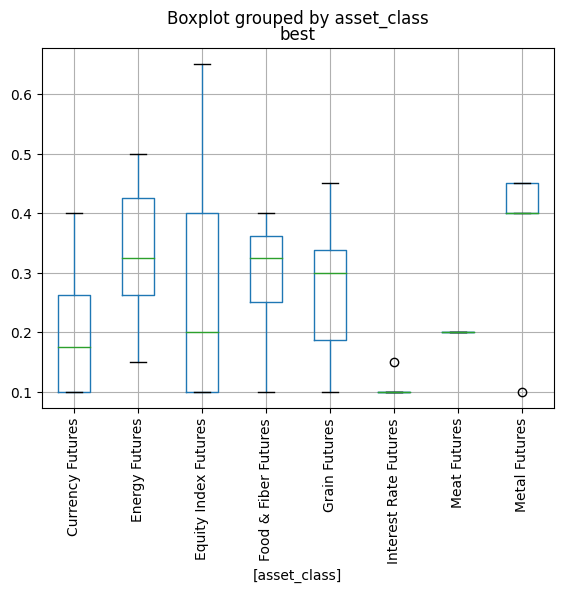

In [7]:
df[['asset_class', 'best']].boxplot(by='asset_class', rot=90)

c:\ProgramData\Anaconda3\envs\jh39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



<Axes: title={'center': 'Train r2 by exchange hours'}, xlabel='active_hours', ylabel='avg_tr_fr_tr'>

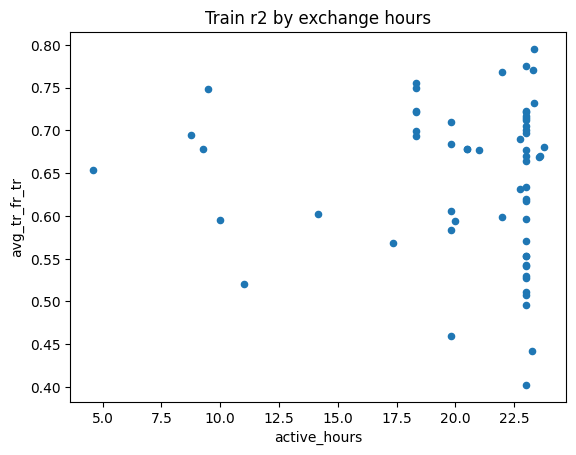

In [8]:
df.plot.scatter(x='active_hours', y='avg_tr_fr_tr', title='Train r2 by exchange hours')

In [10]:
blp = BLP()

df['active_contract'] = df['spot'].apply(lambda x: x.bbg_active_ticker)
active_tickers = df['active_contract'].tolist()
bbg_data = blp.bdp(active_tickers, ['PX_BID','PX_ASK','FUT_TICK_SIZE'])

In [11]:
bbg_data['tick_size_bps'] = (bbg_data['FUT_TICK_SIZE']/bbg_data['PX_BID'])*100*100
bbg_data['ba_spread_size_bps'] = ((bbg_data['PX_ASK']-bbg_data['PX_BID'])/bbg_data['PX_BID'])*100*100

df = pd.merge(df, bbg_data, left_on='active_contract',right_on='Ticker')

In [12]:
reg_df = df.query("tick_size_bps<25")

loglog=True
x_col = 'tick_size_bps'
y_col = 'best'

if loglog:
    y = reg_df[y_col].apply(np.log)
    x = sm.add_constant(reg_df[x_col]).apply(np.log)
else:
    y = reg_df[y_col]
    x = sm.add_constant(reg_df[x_col])
    
x['const']=1

                                     
model = sm.OLS(y, x).fit()
model.params

const           -1.669846
tick_size_bps   -0.130051
dtype: float64

In [13]:
x_axis = np.linspace(reg_df[x_col].min(),reg_df[x_col].max(), 100)
if loglog:
    fit_y = np.exp(model.params.const)*(x_axis**model.params[x_col])
else:
    fit_y = model.params.const + x_axis*model.params[x_col]

Text(0, 0.5, 'best')

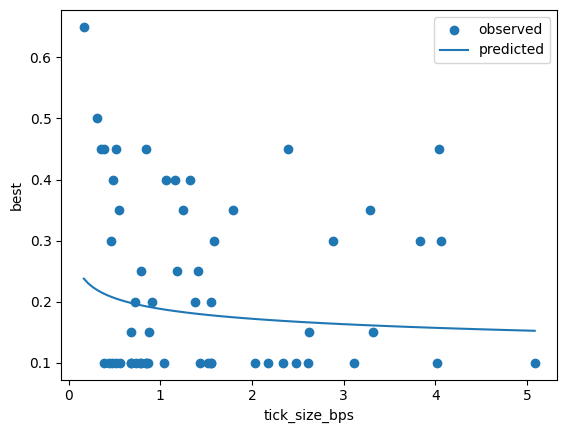

In [14]:
fig, ax = plt.subplots()
ax.scatter(reg_df[x_col], reg_df[y_col], label='observed')
ax.plot(x_axis, fit_y, label='predicted')
ax.legend()
ax.set_xlabel(x_col)
ax.set_ylabel(y_col)